# Uso avanzado de redes recurrentes

In [1]:
import keras

Using TensorFlow backend.


En esta sección revisaremos tres técnicas avanzadas para mejorar el rendimiento y la capacidad de generalización de las redes neuronales recurrentes. Al final de la sección, sabremos la mayor parte de lo que se puede saber acerca del uso de RNNs en Keras.

Ilustraremos las técnicas mediante un problema de predicción meteorológica, donde tendremos acceso a datos de series temporales provenientes de sensores instalados en el tejado de un edificio. Serán sensores de temperatura, presión atmosférica o humedad, que usaremos para predecir la temperatura 24 horas después de la recolección del último dato. Este problema es muy complejo y nos servirá para ilustrar muchas dificultades comunes que nos encontraremos al trabajar con time series.

Cubriremos las siguientes técnicas:
- ***Recurrent dropout***, una forma interna específica de utilizar *dropout* para tratar de evitar el effecto del *overfitting*.
- ***Stacking recurrent layers***, para incrementar la representatividad de la red (a costa de increemntar el coste computacional).
- ***Bidirectional recurrent layers***, que presentan la misma información a la RNN de formas diferentes, incrementando el *accuracy* y mitigando problemas de olvidos.

## Un problema de predicción meteorológica

Hasta ahora, los únicos datos secuenciales que habíamos visto estaban constituídos por texto, e.g. el dataset IMDB. Sin embargo, los datos secuenciales aparecen en muchas otros problemas aparte del procesamiento del lenguaje.

En los ejemplos de esta sección trabajaremos con un dataset de timeseries con datos meteorológicos recogidos en la estación meteorológica situada en el *Max-Plank-Institute for Biogeochemestry* en Jena, Alemania: http://www.bgc-jena.mpg.de/wetter/.

En este dataset se recogen catorce medidas diferentes, como temperatura, presión atmosférica, humedad, dirección del viento, etc., medidas cada diez minutos durante varios años. El dataset original llega hasta 2003, pero nosotros nos limitaremos al periodo 2009-2016.

Este dataset es perfecto para trabajar con timeseries numéricas. Lo utilizaremos para, a partir de algunos datos del pasado reciente (unos pocos días), predecir la temperatura ambiente 24 horas después.

Echemos un ojo a los datos:

In [2]:
import os

data_dir = ''
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Convertimos las 420,552 lineas de datos en un Numpy array:

In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

Por ejemplo, aquí vemos la gráfica de la temperatura (en Celsius) a lo largo del tiempo:

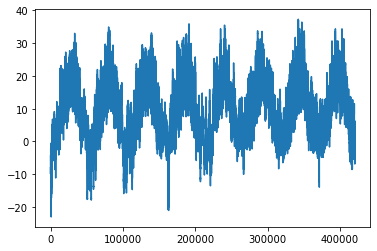

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

Se aprecia claramente la periodicidad anual de la temperatura.

Aquí tenemos una gráfica más concreta, correspondiente a los diez primeros días (como se recogen datos cada diez minutos, se obtienen 144 datos por día):

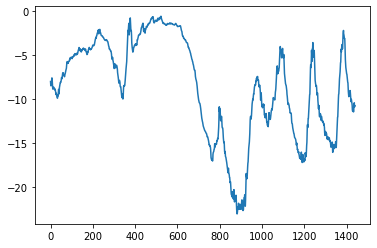

In [5]:
plt.plot(range(1440), temp[:1440])
plt.show()

Se aprecia una cierta periodicidad diaria bastante evidente en los últimos cuatro días. Además, estos días se localizan en un mes frío de invierno.

Una predicción para un mes, dados los datos de meses pasados parece asequible dada la periodicidad anual aparente. Sin embargo, en una escala de días la temperatura parece ser algo caótica.

¿Será esta serie temporal predecible en una escala de días? Averigüémoslo.

## Preparación de los datos

La formulación exacta de nuestro problema será la siguiente: dados datos que se remontan en el pasado *lookback timesteps* (un *timestep* es la periodicidad de nuestros datos, i.e. diez minutos) y que muestreamos cada *steps timesteps*, ¿podemos predecir la temperatura en *delay timesteps*?

Utilizamos los siguientes parámetros:
- lookback = 720, i.e. vamos hacia atrás 5 días.
- steps = 6, i.e. muestreamos un dato por hora.
- delay = 144, i.e. nuestro *target* estará 24 horas en el futuro.

Para empezar necesitaremos hacer dos cosas:
- Preprocesado de los datos de modo que una red neuronal pueda ingerirlos. Será sencillo ya que los datos son numéricos, luego no precisaremos realizar vectorización alguna. Sin embargo, cada timeserie en los datos viene en una escala diferente (e.g. la temperatura estará entre -20 y +30 normalmente, pero la presión, medida en milibares, estará alrededor de 100). Por tanto, normalizaremos cada timeserie por separado, de modo que todas tomen valores pequeños en una escala similar.
- Crear un generador que tome el array de datos *float* y genere lotes de datos del pasado reciente, así como la temperatura a futuro como *target* asociado. Como las muestras en nuestro dataset serán altamente redundantes (por ejemplo, las muestras N y N+1 tendrán la mayoría de timesteps comunes), sería un malgasto de recursos el situar explícitamente cada muestra. En vez de eso, generaremos las muestras *on-the-fly* utilizando los datos originales.

Preprocesamos los datos restando la media y dividiendo por la desviación típica cada timeserie. Utilizaremos los primeros 200,000 timesteps como datos de entrenamiento, así que calculamos la media y desviación típica sólo para esa fracción de los datos:

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Este es el *data generator* que utilizaremos. Devuelve una dupla ***(samples, targets)*** donde ***samples*** es un lote de *inputs* y ***targets*** es el correspondiente vector de *targets* con las temperaturas ambiente futuras a predecir. Toma los siguientes argumentos:
- data: Los datos originales en forma de matriz de datos en formato de coma flotante, ya normalizados previamente.
- lookback: Número de *timesteps* que nuestros datos de entrada irán hacia atrás.
- delay: Número de *timesteps* en el futuro en el que predeciremos el *target*.
- min_index y max_index: índices en la matriz que delimitan los *timesteps* de los que tomar los datos. Nos será útil para poder separar datos tanto para validación como para test.
- shuffle: Si mezclamos nuestros datos o los consideramos en orden cronológico.
- batch_size: número de muestras por lote.
- step: Periodo, en *timesteps*, en el que muestreamos los datos. Lo fijaremos en 6 para tomar un dato cada hora. 

In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Ahora, usaremos nuestro generador abstracto para inicializar tres generadores (uno para *training*, otro para *validation* y el último para *test*). Cada uno mirará en segmentos diferentes de los datos: el de *training* en los 200,000 primeros *timesteps*, el de *validation* en los 100,000 siguentes y el de *test* en el resto.

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## Baseline por sentido común (sin machine learning)

Antes de lanzarnos a aplicar cajas negras deep learning para (intentar) resolver el problema, probemos un método simple de sentido común que establecerá un *baseline* a partir del cual buscar soluciones mejores que prueben la utilidad modelos de ML más avanzados. Este tipo de soluciones por sentido común son un buen punto de partida cuando (aún) no se conocen soluciones para el problema que tratamos.

Un ejemplo clásico sería el predecir la clase mayoritaria siempre en problemas de clasificación binaria con datos desbalanceados, siendo la *null acuracy* el *baseline* a batir. Ningún método que sea incapaz de batirlo podrá considerarse útil. Sorprendentemente, en ocasiones puede resultar complicado hacerlo.

En nuestro caso, el *approach* de sentido común sería el suponer periodicidad diaria y predecir que la temperatura en 24 horas será la misma que ahora. Lo evaluamos utilizando el *score* Mean Absolute Error (MAE), que sería igual a:

In [9]:
print('np.mean(np.abs(preds - targets))')

np.mean(np.abs(preds - targets))


En nuestro caso:

In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


Este valor de 0.29 no es directamente interpretable al haber estandarizado los datos. Se traduciría a un error absoluto medio de 0.29 * temperature_std, es decir 2.57˚C. Se trata de un error bastante grande que trataremos de mejorar.

## Un approach básico de machine learning

Al igual que tiene sentido el probar un primer método de sentido común, no tiene menos el probar algún modelo de ML simple y barato computacionalmente antes de lanzarse a entrenar RNNs complejas. De este modo podemos comprobar la necesidad o no de la incorporación de esa complejidad.

Probamos un modelo fully connected sencillo con 2 capas densas, donde previamente haremos un aplanamiento. Nótese que no hay función de activación en la capa de salida (típico en problemas de regresión). Para obtener resultados comparables con el método de sentido común, usaremos MAE como *loss*.

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 22ms/step - loss: 1.1853 - val_loss: 0.5623
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3887 - val_loss: 0.2835
Epoch 3/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2859 - val_loss: 0.2061
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2629 - val_loss: 0.3218
Epoch 5/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2531 - val_loss: 0.2877
Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2445 - val_loss: 0.2791
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2390 - val_loss: 0.2639
Epoch 8/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2326 - val_loss: 0.2712
Epoch 9/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2281 - val_loss: 0.3052
Epoch 10/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2254 - val_l

Veamos las curvas de *loss* para entrenamiento y validación:

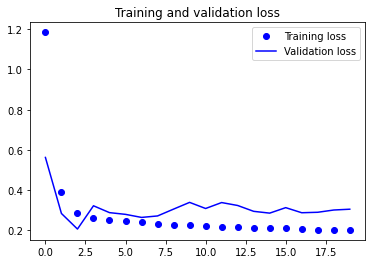

In [12]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Algunos de los valores del *loss* de validación están cerca del valor obtenido en nuestro no-learning baseline, pero sin consistencia. Aquí tenemos una prueba de la necesidad de esos baseline sencillos. No parece que vaya a ser fácil batir ese 0.29.

Cabe preguntarse porqué nuestro modelo deep learning no es capaz de acercarse al resultado naïve. La respuesta es que la red densa no está buscando predecir de la misma manera. Pudiera ocurrir que siendo posible una predicción que da un *loss* de 0.29 (como hemos comprobado) no seamos capaces de dar con un paradigma y una configuración que alcancen esa precisión.

## Un primer baseline recurrente

El primer intento con una red neuronal no fue bien. El realizar un aplanamiento tiene como consecuencia el que se pierde la referencia de secuencia temporal de los datos. Ahora miraremos los datos como lo que son: una secuencia donde la causalidad y el orden importan. Probaremos un modelo recurrente, ya que explotará la secuenciación de los datos, a diferencia del modelo anterior.

En lugar de utilizar capas LSTM, usaremos una capa GRU, creadas por Chao et al. en 2014. Las capas GRU (que proviene de *gated recurrent unit*) sigue el mismo principio que las capas LSTM pero son menos costosas computacionalmente a cambio de tener algo menos de capacidad de representación.

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 97s 193ms/step - loss: 0.2956 - val_loss: 0.3720
Epoch 2/20
500/500 [==============================] - 97s 193ms/step - loss: 0.2819 - val_loss: 0.3385
Epoch 3/20
500/500 [==============================] - 97s 193ms/step - loss: 0.2758 - val_loss: 0.3326
Epoch 4/20
500/500 [==============================] - 97s 194ms/step - loss: 0.2700 - val_loss: 0.3832
Epoch 5/20
500/500 [==============================] - 97s 193ms/step - loss: 0.2664 - val_loss: 0.3599
Epoch 6/20
500/500 [==============================] - 99s 197ms/step - loss: 0.2627 - val_loss: 0.3606
Epoch 7/20
500/500 [==============================] - 97s 193ms/step - loss: 0.2564 - val_loss: 0.3606
Epoch 8/20
500/500 [==============================] - 98s 197ms/step - loss: 0.2527 - val_loss: 0.3227
Epoch 9/20
500/500 [==============================] - 99s 199ms/step - loss: 0.2496 - val_loss: 0.3590
Epoch 10/20
500/500 [==============================] - 100s 199ms/step - 

Veamos los resultados:

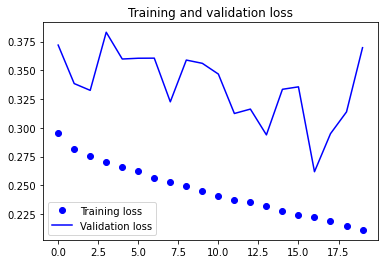

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

¡Mucho mejor! Hemos superado significativamente el baseline. El nuevo *validation loss* de ~0.265 (antes de hacer sobreajuste) se traduce en un error absoluto medio de 2.35˚C frente a los 2.57˚C de partida. Es una buena ganancia pero probablemente aún tengamos margen de mejora.

## Uso de recurrent dropout para paliar el overfitting

El overfitting en el modelo anterior es obvio y ocurre muy temprano. Ya sabemos en que consiste el dropout ("esconder" un porcentaje de los datos a la red para que no pueda ajustarse a ellos al no verlos), pero cómo usarlo en redes recurrentes no es trivial. Es sabido que aplicarlo anter de un layer recurrente obstaculiza el aprendizaje más que regulariza.

En 2015, Yarin Gal, como parte de su tesis doctoral en deep learning Bayesiano, determinó la forma adecuada de aplicar dropout en redes recurrentes: ha de aplicarse en cada timestep el mismo patrón de unidades ignoradas. Más aún, en capas como LSTM o GRU un patrón constante debe ser aplicado en las activaciones recurrentes (*recurrent dropout mask*). De este modo la propagación del error a través del tiempo es correcta al no ser corrompida por la aleatoriedad en cada loop.

El propio Yarin Gal utilizó Keras en su estudio e incorporó sus ideas al mismo como developer. Todo layer recurrente en Keras dispone de dos parámetros relacionados con dropout: ***dropout***, float indicando el dropout rate para el layer de entrada y ***recurrent_dropout***, específico para las unidades recurrentes. Utilicemos ambas estrategias en nuestra red GRU. Como las redes regularizadas mediente dropout tardan más en converger, entrenamos la red el dobe de epochs.

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 101s 201ms/step - loss: 141570595862741680128.0000 - val_loss: 0.3974
Epoch 2/40
500/500 [==============================] - 102s 203ms/step - loss: 132275773747207716864.0000 - val_loss: 0.4392
Epoch 3/40
500/500 [==============================] - 102s 204ms/step - loss: 132476435349352546304.0000 - val_loss: 0.4114
Epoch 4/40
500/500 [==============================] - 101s 203ms/step - loss: 128432225212855959552.0000 - val_loss: 0.4360
Epoch 5/40
500/500 [==============================] - 101s 203ms/step - loss: 134783631536322625536.0000 - val_loss: 0.4170
Epoch 6/40
500/500 [==============================] - 101s 203ms/step - loss: 130793131038711021568.0000 - val_loss: 0.4354
Epoch 7/40
500/500 [==============================] - 101s 202ms/step - loss: 134286280359764672512.0000 - val_loss: 0.4353
Epoch 8/40
500/500 [==============================] - 102s 204ms/step - loss: 132636455371147378688.0000 - val_loss: 0.4192
Epoch 9/

KeyboardInterrupt: 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Un gran resultado. No hay overfitting durante las primeras 30 epochs. No obstante, pese a que tenemos una mayor estabilidad, nuestro mejor score no mejora en exceso el mejor resultado visto hasta ahora.

## Stacking de capas recurrentes

Como ya no hay overfitting, parece ser que nuestra red no es capaz de afinar más (*performance bottleneck*). Es hora de incrementar la capacidad de nuestra red. En general es buena idea incrementar la capacidad de la red hasta que se produce un overfitting pese al uso de estrategias correctoras (como dropout).

La forma usual de incrementar la capacidad es aumentar el número de neuronas en las capas o aumentar el número de capas. *Recurrent layer stacking* es una estrategia clásica de aumento de capacidad. Por ejemplo, actualmente Google translate es un stack de siete capasLSTM grandes, lo que es enorme.

Para hacer un stack con capas recurrentes, las capas intermedias deben devolver la secuencia total de outputs (que es un tensor 3D) en lugar de su output en el último timestamp. Se hace eligiendo return_sequences=True:

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Miremos los resultados

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Vemos que no hay una mejoría significativa.

Podemos extraer dos conclusiones:
- Como no sufrimos un overfitting severo podríamos incrementar sin miedo el tamaño de nuestros layers para tratar de mejorar el *validation loss*. Además el incremento en el coste computacional es despreciable
- Como añadir una capa no ha ayudado mucho, cabe plantearse el disminuir el retorno de secuencias para incrementar la capacidad en ese punto

## Uso de RNNs bidireccionales

La última técnica que veremos es el uso de RNNs bidireccionales. Una bidireccional es una variante común de las RNNs que suele funcional mejor que las RNNs usuales en algunas tareas, por ejemplo el procesamiento de lenguaje natural (NLP por *natural languaje processing*).

Las RNNs tratan los datos secuencialmente. Un shuffle o una inversión del orden temporal hacen que las representaciones extraidas de la secuencia sean totalmente diferentes. Ese tratamiento secuencial es el que permite un buen resultado en un problema como el que nos atañe.

Un RNN bidireccional explota la sensibilidad al orden de las RNNs. Consiste en dos RNNs normales (e.g. LSTM o GRU) cada una de las cuales usa la frecuencia en una dirección (cronológica y anticronológicamente), uniendo después sus representaciones. El recorrido en ambas direcciones permite identificar patrones que podrían ser ignorados por la red ordenada cronológicamente.

Teniendo en cuenta que el orden cronológico utilizado en los modelos hasta ahora puede considerarse una decisión arbitraria, cabe preguntarse qué habría pasado con una RNN unidireccional con secuencias ordenadas anticronológicamente.

Comprobémoslo. Para ello basta modificar el data generator cambiando su última línea por ***yield samples[:, ::-1, :], targets)***

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Luego el orden inverso perjudica seriamente al modelo, que está lejos incluso del modelo baseline inicial. Tiene sentido ya que el layer GRU tendrá más problemas para recordar la información más antigua (que es la más reciente en el anticronológico). 

Aunque parece un argumento lógico universal no es siempre trivialmente cierto. Por ejemplo, en NLP la importancia de una palabra para entender una frase no suele depender de la posición de la palabra en la misma. Probamos el mismo truco en la LSTM para los datos IMDB:

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

El resultado es casi idéntico con ambas ordenaciones, lo que indica que el orden de las palabras en la frase contribuye al entendimiento en mucha menor medida que las palabras en sí. No obstante, en ambos casos se aprenderían representaciones diferentes, lo que hace que merezca la pena el doble esfuerzo. Además sería posible el plantearse estrategias de aprovechamiento conjunto, como *ensemble learning*.

Una RNN bidireccional explota la idea de mejorar el resultado de la RNN cronológica considerando las representaciones obtenidas con ambas ordenaciones conjuntamente.

In [ ]:
from IPython.core.display import Image, display
display(Image(filename='BidirectionalRNN.png'))

Para inicializar una RNN bidireccional en Keras se usa una capa ***Bidirectional***, que toma como primer argumento una capa recurrente. Se creará una segunda instancia en orden anticronológico separada de modo que una procesa las secuencias de entrada en un orden y la otra en el inverso.

Lo probamos en el problema de *sentiment analysis* con IMDB:

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Funciona un poco mejor que la LSTM básica, llegando a un 88% de validation accuracy. Parece que hay algo de overfitting, lo que es lógico al tener el doble de parámetros que la LSTM cronológica. Con algo de regularización la bidireccional será muy competitiva en este dataset.

Probemos ahora el el problema de predicción meteorológica:

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Funciona casi igual que el GRU cronológico. Tiene sentido ya que parece que toda la capacidad predictiva está en la mitad cronológica de la bidireccional.

## Yendo más allá

Aún hay muchas otras cosas que podríamos hacer para tratar de mejorar nuestro modelo:
- Ajustar el número de neuronas en cada layer recurrente al hacer stack. Nuestras elecciones han sido arbitrarias, luego potencialmente subóptimas.
- Ajustar el learning rate del optimizer.
- Usar layers LSTM en lugar de GRU.
- Usar un dense layer mayor o con más capas.
- No olvidar probar eventualmente los modelos en el test set separado a tal efecto (en términos del MAE).

Todo problema es único y habrá que probar y evaluar diferentes estrategias empíricamente. Probar e iterar.